In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [20]:
from pprint import pprint
from copy import copy
import time
import warnings
from itertools import cycle, islice
import sys

from astropy.stats import gaussian_sigma_to_fwhm
from astropy.coordinates import SkyCoord, search_around_sky
from astropy.nddata import Cutout2D
from astropy.table import Table, hstack, vstack, unique
from astropy.wcs import wcs
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as uu
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar, colors
from matplotlib.colors import LogNorm
import matplotlib.markers as mmarkers
import matplotlib.font_manager as fm
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
from loguru import logger

from uvva.field import BaseField, GALEXField
from uvva.utils import extr_value

In [3]:
# replacing the standard handler
try:
    logger.remove(0)
except ValueError:
    print("[Loguru]: Default handler already removed.")

# setup custom handler to make use of
# additional fields defined by uvva
fmt = (
    "<g>{time:YYYY-MM-DD HH:mm:ss.SSS}</> | "
    "<lvl>{level: ^8}</> | "
    "<c>{name}</>:<c>{line}</> in <c>{extra[classname]}</>:<c>{function}</> | "
    "<lvl>{message}</>"
)
logger.add(sys.stdout, format=fmt, backtrace=False, level="INFO")
# activate logging (is deactivated by import of uvva)
logger.enable("uvva")

In [10]:
"""
list of fields
2552663716076191744 NGS 32 visits
2424979629631602688 MIS 5 visits
2508155485249601536 DIS 5 visits
6388191295067652096 NGC4993-GW170817 2 visits

TDS fields
2605053246158405632 PS_COSMOS_MOS23 DIS 29 visits 
2593653509626789888 PS_CDFS_MOS00 DIS 114 visits 
2594075722091855872 PS_CDFS_MOS06 DIS 29 visits 
2607375414741434368 PS_GROTH_MOS06 DIS 18 visits 
"""

# filed ID
field_id = 6388191295067652096

# initialize field analysis
from_archive = True
from_fits = False

if from_archive:
    gf = GALEXField.from_archive(obs_id=field_id, filter="NUV", refresh=False)
    fits_path = f"{gf.data_path}/{gf.uvva_file_prefix}_field_data.fits"
    gf.write_to_fits(fits_path)
elif from_fits:
    gf = GALEXField.from_fits(obs_id=field_id, filter="NUV")


2022-02-11 11:48:52.803 |   INFO   | uvva.field:246 in GALEXField:add_table | Adding table 'base_field:tt_field'
2022-02-11 11:48:52.878 |   INFO   | uvva.field:246 in GALEXField:add_table | Adding table 'galex_field:tt_visits'
2022-02-11 11:48:55.701 |   INFO   | uvva.field:246 in GALEXField:add_table | Adding table 'galex_field:tt_detections'
2022-02-11 11:48:55.707 |   INFO   | uvva.field:246 in GALEXField:add_table | Adding table 'galex_field:tt_ref_sources'
2022-02-11 11:48:55.713 |   INFO   | uvva.field:226 in GALEXField:load_sky_map | Loading skypmap from file: '/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/Science/cloud/uc_science/uvvarcat/GALEX_fields/6388191295067652096/mastDownload/GALEX/6388191295067652096/AIS_491_sg12-nd-int.fits.gz'
2022-02-11 11:48:56.144 |   INFO   | uvva.field:677 in GALEXField:from_archive | Loaded new GALEX field '6388191295067652096' with filter 'NUV' from MAST data.
2022-02-11 11:48:56.145 |   INFO   | uvva.fiel

In [45]:
# Set additional field paramter
r_cluster = (5.0 * uu.arcsec).to(uu.degree).value  # in deg
r_fov = 0.55  # in deg

In [43]:
# Cluster
params = {
    "quantile": 0.01,
    "bandwidth": r_cluster,
    "bin_seeding": True,
    "min_bin_freq": 10,
    "cluster_all": False,
    "n_jobs": -1,
}
gf.cluster_meanshift(params["bandwidth"])

2022-02-11 12:26:24.580 |   INFO   | uvva.field:277 in GALEXField:cluster_meanshift | Clustering sources
2022-02-11 12:26:24.587 |   INFO   | uvva.field:285 in GALEXField:cluster_meanshift | MeanShift with bandwidth '0.001388888888888889'
2022-02-11 12:26:34.533 |   INFO   | uvva.field:246 in GALEXField:add_table | Adding table 'base_field:tt_sources'
2022-02-11 12:26:34.534 | WARNING  | uvva.field:251 in GALEXField:add_table | Table 'tt_sources' already exists, overwriting


6339

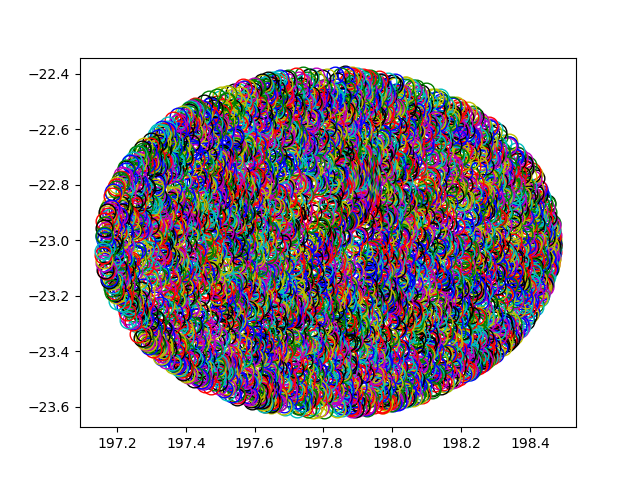

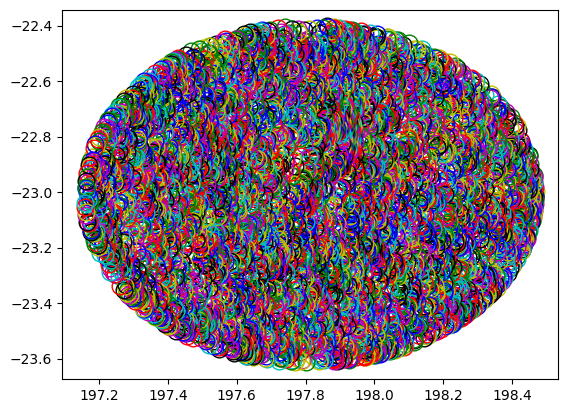

In [12]:
gf.plot_sky(True, True)

In [21]:
# Distance to nearest neighbor    
def get_hist_bins(data, bin_size, is_list=False):
    
    # get minimum and maximum rounded to integer
    if is_list:
        vmin = np.floor(extr_value(data))
        vmax = np.ceil(extr_value(data, upper=True))
    else:
        vmin = np.floor(np.min(data))
        vmax = np.ceil(np.max(data))
    # generate bin array
    bins = np.arange(vmin, vmax, bin_size)
    return bins

range 0.0 113.0
range diff 113
bin size 1
number of bins 113


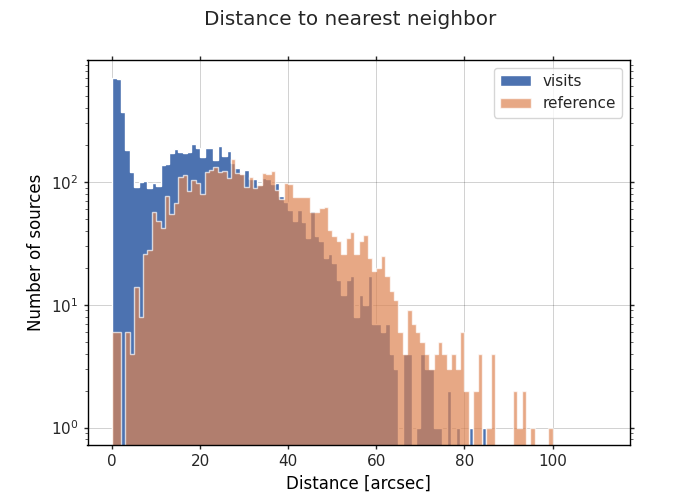

In [37]:
# Plot nearest neighbor distance
pos_visit = SkyCoord(gf.tt_detections["ra"], gf.tt_detections["dec"], frame="icrs")
pos_ref = SkyCoord(gf.tt_ref_sources["ra"], gf.tt_ref_sources["dec"], frame="icrs")
d_nearest_visit = np.asarray(pos_visit.match_to_catalog_sky(pos_visit, nthneighbor=2)[1].to(uu.arcsec).data)
d_nearest_ref= np.asarray(pos_ref.match_to_catalog_sky(pos_ref, nthneighbor=2)[1].to(uu.arcsec).data)

vmin = np.floor(np.min([d_nearest_visit.min(),d_nearest_ref.min()]))
vmax = np.ceil(np.max([d_nearest_visit.max(),d_nearest_ref.max()]))
bin_size = 1

#bins = int((vmax-vmin) * bin_size)
bins = get_hist_bins(data=[d_nearest_visit, d_nearest_ref], bin_size=bin_size, is_list=True)

print("range", vmin, vmax)
print("range diff",int(vmax-vmin))
print("bin size", bin_size)
print("number of bins", len(bins))

fig_num = 0
plt.close(fig_num)
# use custom style sheet
plt.style.use("../mpl_style_sheets/spie_scout_testing.mplstyle")

fig, axs = plt.subplots(num=fig_num, figsize=(7, 5), constrained_layout=False)
fig.suptitle("Distance to nearest neighbor")

axs.hist(d_nearest_visit, bins=bins, log=True, histtype="stepfilled", label="visits")
axs.hist(d_nearest_ref, bins=bins, log=True, histtype="stepfilled", alpha=0.7, label="reference")

axs.set_xlabel("Distance [arcsec]")
axs.set_ylabel("Number of sources")
axs.legend()


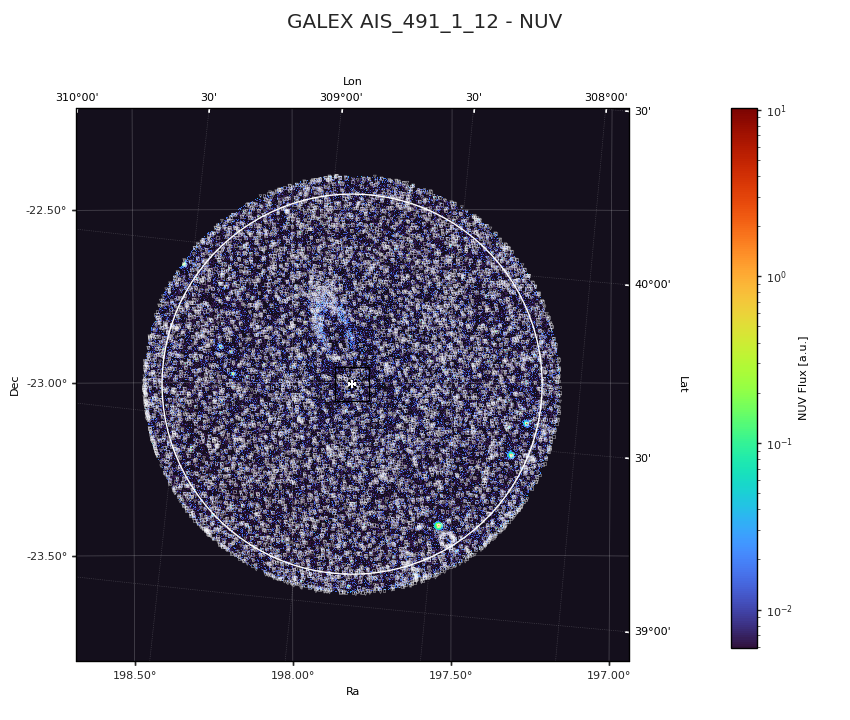

In [76]:
# Plot sky map & cutout

# fits image
ref_int_map = gf.ref_img
# world coordinates
wcs = gf.ref_wcs

# cutout
center = gf.center
position = center
#position = SkyCoord(ra=214.67, dec=52.85, frame="icrs", unit=uu.degree)  # 2607375414741434368 PS_GROTH_MOS06
#position = SkyCoord(ra=151.06, dec=2.235, frame="icrs", unit=uu.degree)  # 2605053246158405632 PS_COSMOS_MOS23 - cutout1 
#position = SkyCoord(ra=150.78, dec=2.3965, frame="icrs", unit=uu.degree)  # 2605053246158405632 PS_COSMOS_MOS23 - cutout2
size = uu.Quantity((0.1, 0.1), uu.deg)
cutout = Cutout2D(ref_int_map.data, position, size, wcs=wcs)

# figure
fig_num = 1
plt.close(fig_num)
fig = plt.figure(num=fig_num, figsize=(8.5, 7.2), constrained_layout=False)
ax = plt.subplot(projection=wcs)

fig.suptitle(f"{gf.observatory} {gf.name} - {gf.obsfilter}")

# set color map
cmap = copy(cm.get_cmap("turbo"))
cmap.set_bad([0.08, 0.06, 0.11])
label_fontsize = 8

# intensity data (flux [a.u.)
img = ax.imshow(
    ref_int_map.data,
    cmap=cmap,
    norm=LogNorm(),
    origin="lower",
    interpolation="none",
)
show_ref = True
show_sources = True
if show_ref:
    ax.scatter(
        gf.tt_ref_sources["ra"],
        gf.tt_ref_sources["dec"],
        transform=ax.get_transform("world"),
        s=2**2,
        edgecolor="white",
        facecolor="none",
        lw=0.5,
        marker="s",
        alpha=0.5,
    )
if show_sources:
    ax.scatter(
        gf.tt_sources["ra"],
        gf.tt_sources["dec"],
        transform=ax.get_transform("world"),
        s=2**2,
        edgecolor="white",
        facecolor="none",
        lw=0.5,
        marker="v",
        alpha=0.5,
    )

# cutout box
cutout.plot_on_original(color="k")
# cutout center coodinate
ax.scatter(position.ra, position.dec, transform=ax.get_transform("world"), c="k", marker="x")
# field of view cut
ax.scatter(center.ra, center.dec, transform=ax.get_transform("world"), c="w", marker="+")
s = SphericalCircle((center.ra, center.dec), r_fov * uu.deg,
                    edgecolor='white', facecolor='none',
                    transform=ax.get_transform('world'))
ax.add_patch(s)

ax.coords.grid(True, color='white', ls='solid')

# set axis labels
ra = ax.coords["ra"]
dec = ax.coords["dec"]
ra.set_major_formatter("d.dd")
dec.set_major_formatter("d.dd")

ax.set_xlabel("Ra", fontsize=label_fontsize)
ax.set_ylabel("Dec", fontsize=label_fontsize)
ax.xaxis.set_tick_params(labelsize=label_fontsize)
ax.yaxis.set_tick_params(labelsize=label_fontsize)
ax.tick_params(axis="x", labelsize=label_fontsize, bottom=True, top=False)
ax.tick_params(axis="y", labelsize=label_fontsize, left=True, right=False)

 # grid
overlay = ax.get_coords_overlay("galactic")
overlay.grid(color="white", ls="dotted")
labels = ["Lon", "Lat"]
ticks_pos = ["t", "r"]
for i in range(2):
    overlay[i].set_axislabel(labels[i], fontsize=label_fontsize)
    overlay[i].set_ticklabel(color="k", size=label_fontsize)
    overlay[i].set_ticks(color="white", direction="in")
    overlay[i].set_ticks_position(ticks_pos[i])

# add color bar
# colorbar
cbaxes = fig.add_axes([0.86, 0.1, 0.03, 0.75])
cbaxes.grid(False)
cb = colorbar.Colorbar(
    ax=cbaxes,
    mappable=img,
    #orientation="vertical",
)
cb.ax.tick_params(labelsize=label_fontsize)
cb.set_label("NUV Flux [a.u.]", size=label_fontsize)

plt.subplots_adjust(
            left=-0.05, bottom=0.082, right=0.88, top=0.85, wspace=0.2, hspace=0.20
        )